In [14]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [15]:
df_p100 = pd.read_csv("emissions_P100_combined.csv")
df_v100 = pd.read_csv("emissions_V100_combined.csv")

df_p100_256 = df_p100.iloc[0:100].copy()
df_p100_512 = df_p100.iloc[100:200].copy()


df_v100_256 = df_v100.iloc[0:100].copy()
df_v100_512 = df_v100.iloc[100:200].copy()

In [16]:
df_p100_256["gpu"] = "P100"
df_p100_512["gpu"] = "P100"
df_v100_256["gpu"] = "V100"
df_v100_512["gpu"] = "V100"

df_p100_256["architecture"] = "BigGAN-256"
df_p100_512["architecture"] = "BigGAN-512"
df_v100_256["architecture"] = "BigGAN-256"
df_v100_512["architecture"] = "BigGAN-512"

In [17]:
df_all = pd.concat(
    [df_p100_256, df_p100_512, df_v100_256, df_v100_512], ignore_index=True
)

images_per_batch = 50
df_all["emissions_per_image"] = df_all["emissions"] / images_per_batch

In [18]:
df_all["ram_power"].unique()

# ram_power remained constant throughout. Something to note...

array([94.35782862])

### Analysis with all GPUs and model architectures

    gpu architecture  mean_emissions  std_emissions  mean_duration  \
0  P100   BigGAN-256        0.000211       0.000008       9.827027   
1  P100   BigGAN-512        0.000559       0.000130      22.043227   
2  V100   BigGAN-256        0.000255       0.000051      10.405159   
3  V100   BigGAN-512        0.000396       0.000030      16.326491   

   std_duration  mean_per_image  
0      0.617445        0.000004  
1      4.837463        0.000011  
2      1.777986        0.000005  
3      0.776761        0.000008  


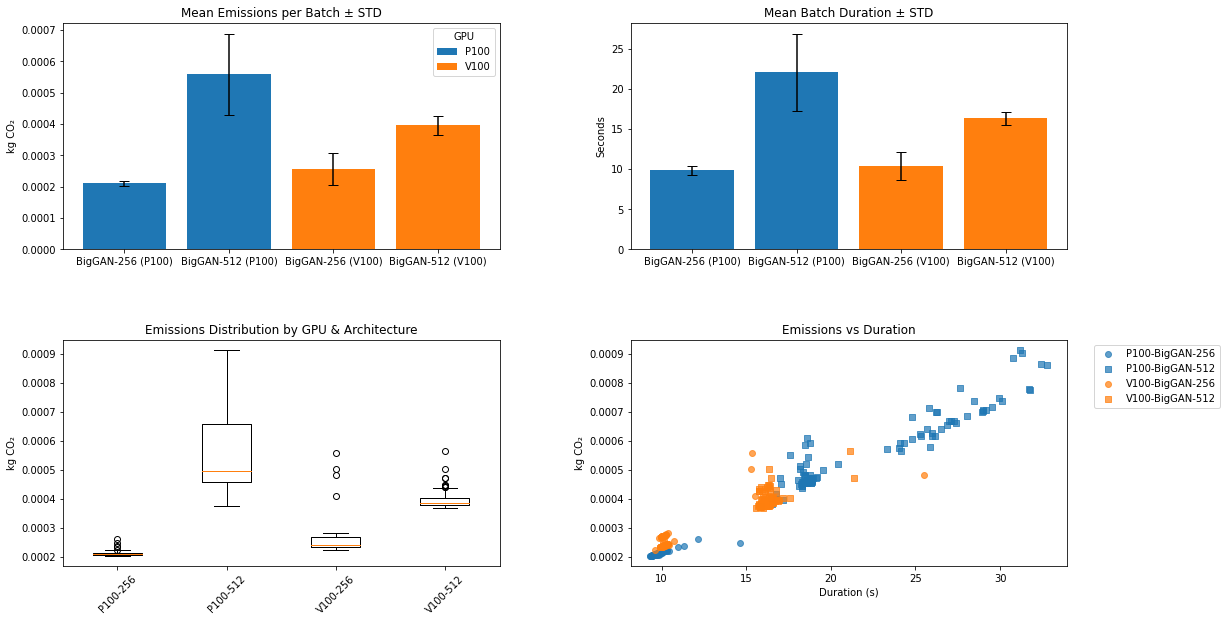

In [19]:
IMAGE_COUNT = 50
df_all["emissions_per_image"] = df_all["emissions"] / IMAGE_COUNT

# Summary stats by (gpu, architecture)
summary = (
    df_all.groupby(["gpu", "architecture"])
    .agg(
        mean_emissions=("emissions", "mean"),
        std_emissions=("emissions", "std"),
        mean_duration=("duration", "mean"),
        std_duration=("duration", "std"),
        mean_per_image=("emissions_per_image", "mean"),
    )
    .reset_index()
)

# Display summary table
print(summary)

# 2x2 plot grid
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# 1) Mean Emissions ± STD by GPU & Architecture
for (gpu), group in summary.groupby("gpu"):
    axes[0, 0].bar(
        group["architecture"] + f" ({gpu})",
        group["mean_emissions"],
        yerr=group["std_emissions"],
        capsize=5,
        label=gpu,
    )
axes[0, 0].set_title("Mean Emissions per Batch ± STD")
axes[0, 0].set_ylabel("kg CO₂")
axes[0, 0].legend(title="GPU")

# 2) Mean Duration ± STD
for (gpu), group in summary.groupby("gpu"):
    axes[0, 1].bar(
        group["architecture"] + f" ({gpu})",
        group["mean_duration"],
        yerr=group["std_duration"],
        capsize=5,
    )
axes[0, 1].set_title("Mean Batch Duration ± STD")
axes[0, 1].set_ylabel("Seconds")

# 3) Boxplot of Emissions Distribution
data_boxes = [
    df_p100_256["emissions"],
    df_p100_512["emissions"],
    df_v100_256["emissions"],
    df_v100_512["emissions"],
]
labels = ["P100-256", "P100-512", "V100-256", "V100-512"]
axes[1, 0].boxplot(data_boxes, labels=labels)
axes[1, 0].set_title("Emissions Distribution by GPU & Architecture")
axes[1, 0].set_ylabel("kg CO₂")
axes[1, 0].tick_params(axis="x", rotation=45)

# 4) Scatter: Duration vs Emissions
markers = {"BigGAN-256": "o", "BigGAN-512": "s"}
colors = {"P100": "C0", "V100": "C1"}
for gpu in ["P100", "V100"]:
    for arch in ["BigGAN-256", "BigGAN-512"]:
        sub = df_all[(df_all["gpu"] == gpu) & (df_all["architecture"] == arch)]
        axes[1, 1].scatter(
            sub["duration"],
            sub["emissions"],
            label=f"{gpu}-{arch}",
            marker=markers[arch],
            color=colors[gpu],
            alpha=0.7,
        )
axes[1, 1].set_title("Emissions vs Duration")
axes[1, 1].set_xlabel("Duration (s)")
axes[1, 1].set_ylabel("kg CO₂")
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()

In [20]:
groups = df_all.groupby(["gpu_model", "architecture"])

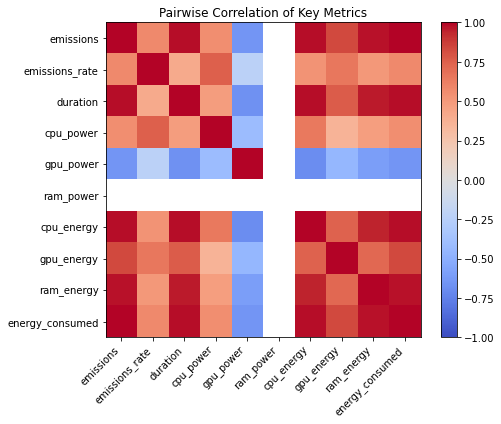

In [21]:
metrics = [
    "emissions",
    "emissions_rate",
    "duration",
    "cpu_power",
    "gpu_power",
    "ram_power",
    "cpu_energy",
    "gpu_energy",
    "ram_energy",
    "energy_consumed",
]

corr = df_all[metrics].corr()

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm")
ax.set_xticks(np.arange(len(metrics)))
ax.set_yticks(np.arange(len(metrics)))
ax.set_xticklabels(metrics, rotation=45, ha="right")
ax.set_yticklabels(metrics)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Pairwise Correlation of Key Metrics")
plt.tight_layout()
plt.show()

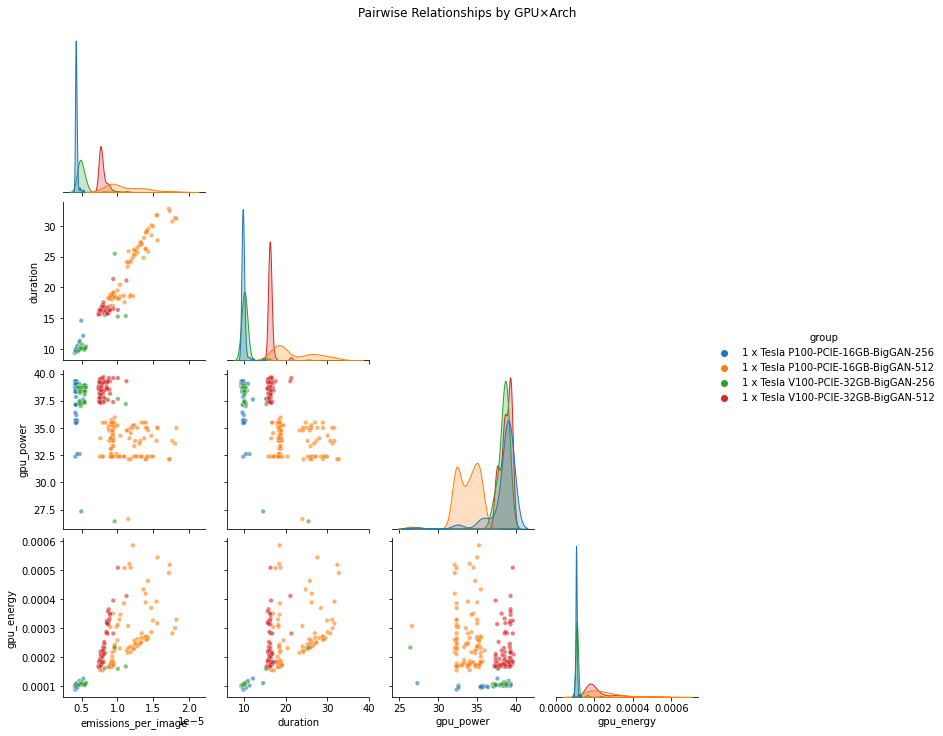

In [22]:
df_all["group"] = df_all["gpu_model"] + "-" + df_all["architecture"]

# Select a handful of numeric columns to plot
cols = ["emissions_per_image", "duration", "gpu_power", "gpu_energy"]

sns.pairplot(
    df_all,
    vars=cols,
    hue="group",
    corner=True,  # only lower half
    plot_kws={"alpha": 0.6, "s": 20},
)
plt.suptitle("Pairwise Relationships by GPU×Arch", y=1.02)
plt.show()

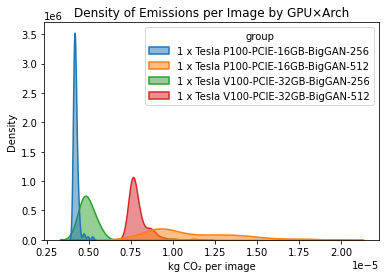

In [23]:
plt.figure(figsize=(6, 4))
sns.kdeplot(
    data=df_all,
    x="emissions_per_image",
    hue="group",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=1.5,
)
plt.title("Density of Emissions per Image by GPU×Arch")
plt.xlabel("kg CO₂ per image")
plt.ylabel("Density")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


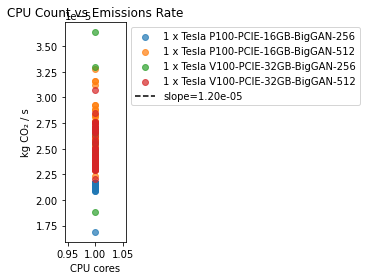

In [24]:
plt.figure(figsize=(5, 4))
for group, sub in df_all.groupby("group"):
    plt.scatter(sub["cpu_count"], sub["emissions_rate"], label=group, alpha=0.7)

# Fit global regression
m, b = np.polyfit(df_all["cpu_count"], df_all["emissions_rate"], 1)
x = np.array([df_all["cpu_count"].min(), df_all["cpu_count"].max()])
plt.plot(x, m * x + b, "k--", label=f"slope={m:.2e}")
plt.title("CPU Count vs Emissions Rate")
plt.xlabel("CPU cores")
plt.ylabel("kg CO₂ / s")
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

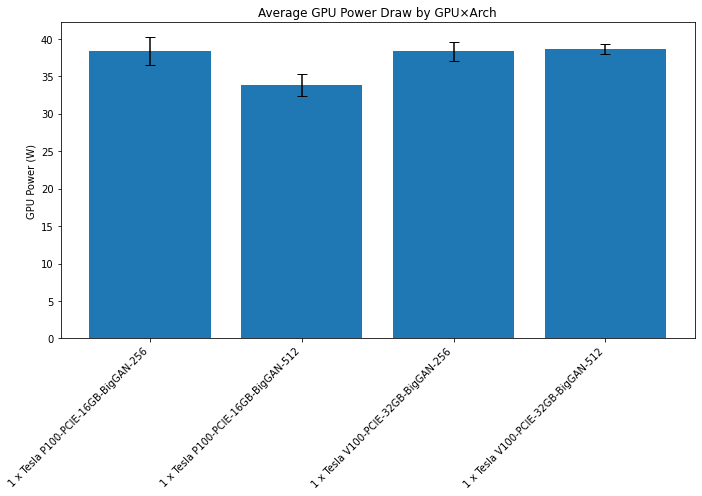

In [25]:
fig, ax = plt.subplots(figsize=(10, 7))
x = range(len(summary))
summary = (
    df_all.groupby(["gpu_model", "architecture"])["gpu_power"]
    .agg(["mean", "std"])
    .reset_index()
)

ax.bar(x, summary["mean"], yerr=summary["std"], capsize=5)
ax.set_xticks(x)
ax.set_xticklabels(
    summary["gpu_model"] + "-" + summary["architecture"], rotation=45, ha="right"
)
ax.set_ylabel("GPU Power (W)")
ax.set_title("Average GPU Power Draw by GPU×Arch")
plt.tight_layout()
plt.show()

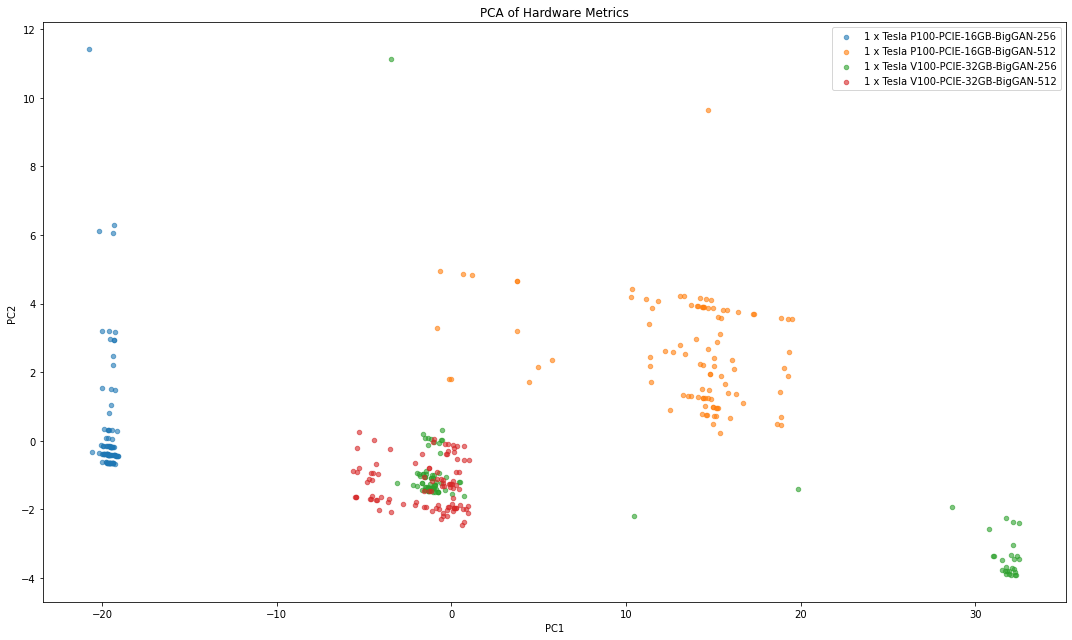

In [26]:
features = [
    "cpu_power",
    "gpu_power",
    "ram_power",
    "cpu_energy",
    "gpu_energy",
    "ram_energy",
]
X = df_all[features].fillna(0)
pca = PCA(n_components=2).fit_transform(X)

df_all["group"] = (
    df_all["gpu_model"].astype(str) + "-" + df_all["architecture"].astype(str)
)
df_all["PC1"], df_all["PC2"] = pca[:, 0], pca[:, 1]

plt.figure(figsize=(15, 9))
for group, sub in df_all.groupby("group"):
    plt.scatter(sub["PC1"], sub["PC2"], label=group, alpha=0.6, s=20)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Hardware Metrics")
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()